### **Descarga e importe de bibliotecas**

In [1]:
%%capture
# Instalar y actualizar bibliotecas necesarias
!pip install kagglehub
!sudo apt-get update
!sudo apt-get install tesseract-ocr
!pip install pytesseract opencv-python

In [2]:
%%capture
# Importar bibliotecas a usar
import os
import yaml
import random
import shutil
import kagglehub
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gdown
import numpy as np
import cv2
import time
import re
import pytesseract
import pandas as pd

from PIL import Image

In [3]:
# Definir la ruta de la carpeta donde están las imágenes
input_dir = "/kaggle/input/pruebas-rgb/PRUEBAS_RGB"  # Cambia esta ruta según corresponda

# Listamos todos los archivos de imagen en el directorio
image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print("Archivos de imagen encontrados:")
print(image_files)

Archivos de imagen encontrados:
['14.jpeg', '45.jpg', '56.jpg', '89.jpg', '18.jpeg', '58.jpg', '76.jpg', '71.jpg', '16.jpeg', '31.jpeg', '25.jpeg', '84.jpg', '85.jpg', '67.jpg', '27.jpeg', '22.jpeg', '24.jpeg', '82.jpg', '97.jpg', '42.jpg', '6.jpeg', '9.jpeg', '54.jpg', '62.jpg', '61.jpg', '11.jpeg', '20.jpeg', '59.jpg', '28.jpeg', '73.jpg', '98.jpg', '41.jpg', '94.jpg', '60.jpg', '57.jpg', '39.jpeg', '32.jpeg', '91.jpg', '99.jpg', '4.jpeg', '5.jpeg', '2.jpeg', '69.jpg', '75.jpg', '81.jpg', '46.jpg', '33.jpeg', '44.jpg', '65.jpg', '50.jpg', '19.jpeg', '30.jpeg', '79.jpg', '7.jpeg', '55.jpg', '77.jpg', '80.jpg', '37.jpeg', '21.jpeg', '48.jpg', '23.jpeg', '88.jpg', '64.jpg', '1.jpeg', '43.jpg', '74.jpg', '17.jpeg', '68.jpg', '53.jpg', '83.jpg', '3.jpeg', '35.jpeg', '72.jpg', '13.jpeg', '86.jpg', '36.jpeg', '15.jpeg', '92.jpg', '70.jpg', '34.jpeg', '10.jpeg', '51.jpg', '52.jpg', '29.jpeg', '95.jpg', '96.jpg', '8.jpeg', '63.jpg', '12.jpeg', '87.jpg', '47.jpg', '93.jpg', '38.jpeg', '26.jpeg

### **Definición de Funciones para el correcto funcionamiento del OCR en las imagenes**

In [4]:
def recortar_zona(img, x_start, y_start, width, height):
    return img[y_start:y_start+height, x_start:x_start+width]

# Preprocesamiento + OCR
def extraer_texto_ocr(imagen):
    
    # Convertir a gris
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Umbral (Otsu)
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Invertir para tener texto oscuro sobre fondo claro
    bw = cv2.bitwise_not(bw)
    
    config = "--psm 7 -c tessedit_char_whitelist=0123456789."
    # OCR
    texto = pytesseract.image_to_string(bw, config=config)
    
    return texto.strip()
    
def extraer_numeros(texto):
    # Función sencilla para extraer números del texto
    return re.findall(r'\d+\.?\d*', texto)

### **Visualización del recorte de imagenes**

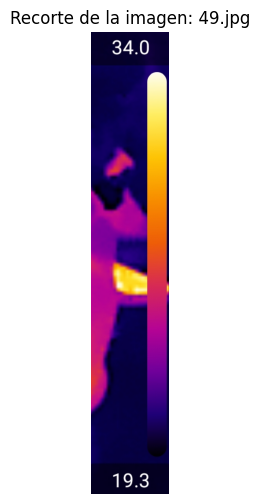

In [6]:
# Definir coordenadas para recortar la barra (x, y, ancho, alto)
# Los valores se tomaron con la ayuda de la herramienta recortar imagen de la pagina "https://www.iloveimg.com/es/recortar-imagen"
x_start = 905   
y_start = 158   
width   = 140  
height  = 830

# Especifica el nombre del archivo que deseas visualizar (debe estar en input_dir)
nombre_imagen = "49.jpg"  # Reemplaza con el nombre real de la imagen

# Cargar la imagen
img_path = os.path.join(input_dir, nombre_imagen)
img = cv2.imread(img_path)

if img is None:
    print(f"Error al cargar la imagen: {nombre_imagen}")
else:
    # Aplicar el recorte de la barra de temperaturas
    recorte = recortar_zona(img, x_start, y_start, width, height)
    
    # Convertir de BGR a RGB para visualizar correctamente con matplotlib
    recorte_rgb = cv2.cvtColor(recorte, cv2.COLOR_BGR2RGB)
    
    # Mostrar la imagen recortada
    plt.figure(figsize=(4,6))
    plt.imshow(recorte_rgb)
    plt.title(f"Recorte de la imagen: {nombre_imagen}")
    plt.axis("off")
    plt.show()

### **Descarga del modelo entrenado e inferencia en imagen de evaluación**

In [8]:
# Descargar el modelo
model_path = kagglehub.model_download("fredycastao/resunet-efficientnetb3-mamitas-seg-tflite/tflite/default/2")

# Especificar la carpeta de destino
output_folder = "./models"
os.makedirs(output_folder, exist_ok=True)

# Mover el modelo a la carpeta de destino
shutil.copy(model_path+'/ResUNet_efficientnetb3_Mamitas.tflite', output_folder)



'./models/ResUNet_efficientnetb3_Mamitas.tflite'

In [9]:
import tensorflow as tf

# Cargar el modelo TFLite
interpreter = tf.lite.Interpreter("./models/ResUNet_efficientnetb3_Mamitas.tflite")
interpreter.allocate_tensors()

# Obtener detalles de entrada y salida del modelo
input_details  = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Detalles de entrada:", input_details)
print("Detalles de salida:", output_details)

Detalles de entrada: [{'name': 'serving_default_image_input:0', 'index': 0, 'shape': array([  1, 512, 512,   3], dtype=int32), 'shape_signature': array([ -1, 512, 512,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Detalles de salida: [{'name': 'StatefulPartitionedCall:0', 'index': 877, 'shape': array([  1, 512, 512,   2], dtype=int32), 'shape_signature': array([ -1, 512, 512,   2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


### **Definición de funcion para extraer la temperatura minima y maxima de la Imagen**

In [10]:
def ocr_range_t(input_dir):
    x_top,   y_top,   w_top,   h_top   = 905, 162, 140, 48   # Medidas de recorte para zona superior
    x_bottom,y_bottom,w_bottom,h_bottom= 905, 940, 140, 48   # Medidas de recorte para zona inferior

    img = cv2.imread(input_dir)
    if img is None:
        print("Error al cargar la imagen")
        return None, None
    
    # Recorte de la zona superior
    recorte_top = recortar_zona(img, x_top, y_top, w_top, h_top)
    # Recorte de la zona inferior
    recorte_bottom = recortar_zona(img, x_bottom, y_bottom, w_bottom, h_bottom)
    
    # Extraer texto con OCR
    texto_top = extraer_texto_ocr(recorte_top)
    texto_bottom = extraer_texto_ocr(recorte_bottom)
    
    # Parsear los números detectados
    top_nums = extraer_numeros(texto_top)
    bottom_nums = extraer_numeros(texto_bottom)

    # Verificar si se detectó el valor máximo
    if not top_nums:
        top_input = input("No se detectó el valor máximo. Ingresa el número manualmente: ")
        # Se guarda como cadena en una lista para mantener la compatibilidad
        top_nums = [top_input]
    
    # Verificar si se detectó el valor mínimo
    if not bottom_nums:
        bottom_input = input("No se detectó el valor mínimo. Ingresa el número manualmente: ")
        bottom_nums = [bottom_input]
    
    print("Valores obtenidos de OCR (o ingresados manualmente):", top_nums, bottom_nums)
    
    return top_nums, bottom_nums


El registro no rígido o deformable permite ajustar la imagen de forma local, corrigiendo deformaciones que no pueden ser modeladas con una simple rotación o traslación. Esta transformación se define como:

$$
T(x) = x + \sum_{i} \phi_i B_i(x)
$$

donde $( x )$ es la posición original, $( \phi_i )$ son los coeficientes de control o los vectores de distancia, y $( B_i(x) )$ son las funciones base de B-splines que suavizan la deformación. Para evaluar qué tan bien se ha alineado la imagen móvil $( I_m )$ con la imagen fija $( I_f )$, se utiliza una función de costo basada en la correlación entre ambas, definida como:

$$
C(I_f, I_m \circ T) = -\text{Corr}(I_f, I_m \circ T)
$$

$$
-\mathrm{Corr}\bigl(I_f, I_m \circ T\bigr) 
= -\frac{\displaystyle \sum_{x} \Bigl(I_f(x) - \overline{I}_f\Bigr)\,\Bigl(I_m\bigl(T(x)\bigr) - \overline{I_m \circ T}\Bigr)}
{\sqrt{\displaystyle \sum_{x} \Bigl(I_f(x) - \overline{I}_f\Bigr)^2}\;\sqrt{\displaystyle \sum_{x} \Bigl(I_m\bigl(T(x)\bigr) - \overline{I_m \circ T}\Bigr)^2}}
$$

De esta forma, al minimizar la función de costo, es decir:

$$
T^* = \arg\min_{T} C(I_f, I_m \circ T)
$$

se maximiza la correlación entre las imágenes, logrando la mejor alineación posible.

In [41]:
from scipy.spatial import Delaunay

In [42]:
def plot_predict(y, y_pred):
    red  = np.logical_and(~y, y_pred)[..., None]  # false positive
    green = np.logical_and(y, y_pred)[..., None]     # true positive
    blue  = np.logical_and(y, ~y_pred)[..., None]     # false negative
    image = np.concatenate((red, green, blue), axis=2).astype('float')
    return image

def define_contour(dermatomes):
    without_contours = dermatomes.copy()
    uniques = sorted(np.unique(without_contours))[1:]
    for unique in uniques:
        binary_img = (without_contours == unique).astype('uint8')
        contours, _ = cv2.findContours(binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        dermatomes = cv2.drawContours(dermatomes, contours, -1, 255, 1)
    return dermatomes

def no_rigid_registration(fixed_image, moving_image):
    """
    1. Extrae el contorno mayor de fixed y de moving.
    2. Muestra N puntos equiespaciados sobre cada contorno.
    3. Calcula la triangulación de Delaunay sobre los puntos de fixed.
    Devuelve: pts_src (N×2), pts_dst (N×2), tri.simplices (M×3 índices de triángulos).
    """
    # binarizar y extraer contornos
    bF = (fixed_image  > 0).astype(np.uint8)*255
    bM = (moving_image > 0).astype(np.uint8)*255
    cF,_ = cv2.findContours(bF, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cM,_ = cv2.findContours(bM, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not cF or not cM:
        raise ValueError("No hay contornos en fixed o moving.")
    # quedarnos con el contorno de mayor área y aplanar
    cntF = max(cF, key=cv2.contourArea).reshape(-1,2)
    cntM = max(cM, key=cv2.contourArea).reshape(-1,2)
    # muestreo equiespaciado
    N = 200
    idxF = np.linspace(0, len(cntF)-1, N).astype(int)
    idxM = np.linspace(0, len(cntM)-1, N).astype(int)
    pts_dst = cntF[idxF]     .astype(np.float32)  # destino = pie
    pts_src = cntM[idxM]     .astype(np.float32)  # origen = plantilla
    # triangulación en el espacio destino
    tri = Delaunay(pts_dst)
    return pts_src, pts_dst, tri.simplices

def resample(moving_image, fixed_image, registration_transform):
    """
    Aplica warp por triangle-wise affine:
    - moving_image: plantilla redim a tamaño foot
    - fixed_image: pie
    - registration_transform: (pts_src, pts_dst, triangles)
    Devuelve plantilla deformada alineada al pie.
    """
    pts_src, pts_dst, tris = registration_transform
    h, w = fixed_image.shape[:2]
    out = np.zeros_like(moving_image)
    # para cada triángulo de la malla
    for tri_inds in tris:
        src_tri = pts_src[tri_inds].astype(np.float32)
        dst_tri = pts_dst[tri_inds].astype(np.float32)
        # máscara del polígono destino
        mask = np.zeros((h,w), np.uint8)
        cv2.fillConvexPoly(mask, np.int32(dst_tri), 1)
        # obtener matriz afín 2×3
        M = cv2.getAffineTransform(src_tri, dst_tri)
        # warp toda la imagen y recortar con la máscara
        warped = cv2.warpAffine(
            moving_image,
            M,
            (w,h),
            flags=cv2.INTER_NEAREST,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=0
        )
        out[mask==1] = warped[mask==1]
    return out

def register_one_foot(foot, dermatomes):
    """
    Redimensiona la plantilla a (h,w)=foot.shape,
    calcula la triangulación, y remapea triángulo a triángulo.
    """
    h, w = foot.shape[:2]
    derm_resized = cv2.resize(dermatomes, (w,h), interpolation=cv2.INTER_NEAREST)
    # 1) calcular correspondencias y triángulos
    reg = no_rigid_registration(fixed_image=foot, moving_image=derm_resized)
    # 2) deformar plantilla
    return resample(moving_image=derm_resized, fixed_image=foot, registration_transform=reg)


def extract_feet(img):
    """Extrae uno o dos pies (ROIs) y sus coordenadas a partir de una máscara binaria."""
    # Asegurarse de que la imagen sea de un solo canal
    if img.ndim != 2:
        # Si la imagen tiene más de un canal, se toma solo el primer canal
        img = img[:,:,0]
    
    img = img.astype('uint8')
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None, None, []
    
    contours = list(contours)
    # Ordenamos de mayor a menor según el área
    contours.sort(reverse=True, key=lambda c: cv2.contourArea(c))
    
    coord = []
    # Procesamos hasta dos contornos
    for c in contours[:2]:
        yBot = c[c[:, :, 1].argmax()][0][1] 
        xRig = c[c[:, :, 0].argmin()][0][0] 
        yTop = c[c[:, :, 1].argmin()][0][1] 
        xLef = c[c[:, :, 0].argmax()][0][0] 
        coord.append([yTop, yBot, xRig, xLef, c])
    
    # Si solo se detectó un contorno, usar ese para el pie derecho y dejar el izquierdo en None
    if len(coord) == 1:
        right_foot = np.zeros_like(img)
        right_foot = cv2.drawContours(right_foot, [coord[0][-1]], -1, 1, -1)
        right_foot = right_foot[coord[0][0]:coord[0][1], coord[0][2]:coord[0][3]]
        return right_foot, None, coord
    
    # Si se detectaron dos, ordenar por la coordenada x para asignar derecha e izquierda
    coord.sort(key=lambda x: x[2])
    right_foot = np.zeros_like(img)
    right_foot = cv2.drawContours(right_foot, [coord[0][-1]], -1, 1, -1)
    right_foot = right_foot[coord[0][0]:coord[0][1], coord[0][2]:coord[0][3]]
    
    left_foot = np.zeros_like(img)
    left_foot = cv2.drawContours(left_foot, [coord[1][-1]], -1, 1, -1)
    left_foot = left_foot[coord[1][0]:coord[1][1], coord[1][2]:coord[1][3]]
    
    return right_foot, left_foot, coord

def get_dermatomes(fixed_mask, path_right_foot, path_left_foot):
    """
    Genera la imagen de dermatomas registrados:
      - fixed_mask: máscara binaria obtenida de YOLO (255 donde hay pie).
      - path_right_foot y path_left_foot: rutas a las plantillas en escala de grises.
    """
    fixed_mask = np.squeeze(fixed_mask)
    right_dermatomes = cv2.flip(cv2.imread(path_right_foot, cv2.IMREAD_GRAYSCALE), 1)
    left_dermatomes = cv2.imread(path_left_foot, cv2.IMREAD_GRAYSCALE)
    left_dermatomes[left_dermatomes != 0] = left_dermatomes[left_dermatomes != 0] + 1 
    
    right_foot, left_foot, coord = extract_feet(fixed_mask)
    
    # Registrar dermatomas para el pie derecho
    if right_foot is not None:
        right_dermatomes_registered = register_one_foot(right_foot, right_dermatomes)
        output_dermatomes = np.zeros_like(fixed_mask, dtype='float')
        output_dermatomes[coord[0][0]:coord[0][1], coord[0][2]:coord[0][3]] = right_dermatomes_registered
    else:
        output_dermatomes = np.zeros_like(fixed_mask, dtype='float')
    
    # Si se detectó también el pie izquierdo, registrarlo y sumarlo
    if left_foot is not None and len(coord) >= 2:
        left_dermatomes_registered = register_one_foot(left_foot, left_dermatomes)
        output_dermatomes[coord[1][0]:coord[1][1], coord[1][2]:coord[1][3]] += left_dermatomes_registered
    
    output_dermatomes = define_contour(output_dermatomes)
    return output_dermatomes
    
def overlay_dermatomes_on_image(original_image, dermatomes):
    # Convertir la imagen original a escala de grises y luego a BGR para poder dibujar en color
    gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    out_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    
    # Recorrer cada etiqueta única (excepto el fondo, valor 0) en el mapa de dermatomas
    unique_labels = np.unique(dermatomes)
    for label in unique_labels:
        if label == 0:
            continue
        # Crear una máscara binaria para la región correspondiente al dermatoma o zona registrada
        mask = (dermatomes == label).astype('uint8')
        # Encontrar los contornos de la máscara
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Dibujar los contornos en rojo con grosor 2
        cv2.drawContours(out_img, contours, -1, (0, 0, 255), 2)
    
    return out_img

### **Función para extraer la temperatura promedio de cada dermatoma** 

In [28]:
def compute_dermatome_temperatures(original_temp, dermatomes):
    """
    Calcula la temperatura promedio para cada dermatoma definido en el diccionario.
    original_temp: mapa de temperaturas (float, mismas dimensiones que la imagen original)
    dermatomes: imagen 2D con etiquetas de dermatomas.
    
    Retorna un diccionario con el nombre del área (de las 5 zonas por pie) y su temperatura promedio.
    Además, imprime un mensaje con la cantidad y lista de etiquetas extra encontradas.
    """
    results = {}
    # Diccionario de nombres: solo se usarán estos dermatomas (5 zonas por pie)
    dic_dermatomes = {
        10: 'Medial Plantar Pie Derecho',
        11: 'Medial Plantar Pie Izquierdo',
        20: 'Lateral Plantar Pie Derecho',
        21: 'Lateral Plantar Pie Izquierdo',
        30: 'Sural Pie Derecho',
        31: 'Sural Pie Izquierdo',
        40: 'Tibial Pie Derecho',
        41: 'Tibial Pie Izquierdo',
        50: 'Saphenous Pie Derecho',
        51: 'Saphenous Pie Izquierdo'
    }
    
    # Obtener todas las etiquetas de la imagen excluyendo fondo (0) y contornos (255)
    unique_labels = [label for label in np.unique(dermatomes) if label not in (0, 255)]
    
    # Calcular la temperatura únicamente para las etiquetas que están en el diccionario
    for label, area_name in dic_dermatomes.items():
        if label in unique_labels:
            region_mask = (dermatomes == label)
            if np.sum(region_mask) > 0:
                mean_temp = original_temp[region_mask].mean()
                results[area_name] = mean_temp
    
    # Identificar las etiquetas extra que aparecen en la imagen pero que no están en el diccionario
    extra_labels = [label for label in unique_labels if label not in dic_dermatomes]
    if extra_labels:
        print(f"Dermatomas extras encontrados: {len(extra_labels)} -> {extra_labels}")
    
    return results

### **Procesamiento final integrado**

In [29]:
def preprocess_for_tflite(image_path, target_size):
    """
    Carga la imagen, la convierte a escala de grises, redimensiona y replica el canal
    para que tenga 3 canales, y finalmente la normaliza (dividiendo entre 255.0) para alimentar el modelo.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"No se encontró la imagen: {image_path}")
    
    # Convertir de BGR a escala de grises
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Redimensionar la imagen en escala de grises
    img_resized = cv2.resize(img_gray, target_size)
    
    # Replicar el canal único a 3 canales para que tenga la forma que requiere el modelo
    img_3ch = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
    
    # Normalizar
    img_norm = img_3ch.astype(np.float32) / 255.0
    
    # Expandir dimensiones para crear un batch de tamaño 1
    input_data = np.expand_dims(img_norm, axis=0)
    return input_data, img

# -------------------------
# Función de Procesamiento Final Integrado
# -------------------------
def process_with_tflite_registration(img_path, img_original_path):
    """
    Procesa la imagen para:
      - Obtener la máscara de segmentación utilizando una imagen convertida a escala de grises y redimensionada a 512×512.
      - Realizar registro no rígido usando plantillas.
      - Extraer los rangos de temperatura mediante OCR en la imagen original (a resolución completa).
      - Calcular las temperaturas promedio por dermatoma.
    """
    # --- Preparar imagen original para OCR y registro ---
    img_full = cv2.imread(img_original_path)
    if img_full is None:
        raise FileNotFoundError(f"No se encontró la imagen: {img_original_path}")
    
    # --- Preprocesamiento para el modelo TFLite (segmentación) ---
    # Esto convierte la imagen original a escala de grises, la redimensiona a (512,512) y replica el canal a 3 canales.
    input_shape = input_details[0]['shape']
    target_size = (input_shape[1], input_shape[2])
    input_data, _ = preprocess_for_tflite(img_path, target_size)
    
    # Configurar el tensor de entrada y ejecutar la inferencia en la imagen procesada (gris y reescalada)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    
    # Obtener la salida del modelo
    mask_output = interpreter.get_tensor(output_details[0]['index'])
    
    # Si la salida tiene múltiples canales (por ejemplo, [1, H, W, 2]), aplicar argmax para obtener una máscara de un canal.
    if mask_output.ndim == 4 and mask_output.shape[-1] > 1:
        mask_output = np.argmax(mask_output, axis=-1)
    mask_output = np.squeeze(mask_output)
    
    # --- Umbralización y postprocesamiento morfológico ---
    # Convertir a binaria: se asume que el modelo produce valores que se pueden umbralizar con 0.5.
    mask_combined = (mask_output > 0.5).astype(np.uint8) * 255
    kernel = np.ones((3,3), np.uint8)
    # Apertura para eliminar ruidos pequeños
    mask_morph = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, kernel, iterations=1)
    # Cierre para rellenar pequeños huecos
    mask_morph = cv2.morphologyEx(mask_morph, cv2.MORPH_CLOSE, kernel, iterations=1)
    # Redimensionar la máscara limpia a la dimensión de la imagen original para registro
    H, W = img_full.shape[:2]
    mask_morph = cv2.resize(mask_morph, (W, H), interpolation=cv2.INTER_NEAREST)
    
    # --- Registro de Dermatomas ---
    # Rutas a la plantilla (imagen de dermatomas)
    path_right_foot = "/kaggle/input/pruebas-rgb/TEMPLATE/dermatomes.png"
    path_left_foot  = "/kaggle/input/pruebas-rgb/TEMPLATE/dermatomes.png"
    t0 = time.time()
    dermatomes = get_dermatomes(mask_morph, path_right_foot, path_left_foot)
    t1 = time.time() - t0
    print(f"[{os.path.basename(img_path)}] Tiempo de registro: {t1:.4f} s")
    
    # --- Conversión a Mapa de Temperaturas (usando la imagen original a alta resolución) ---
    img_float = img_full.astype(np.float32) / 255.0
    max_temp, min_temp = ocr_range_t(img_original_path)
    if isinstance(max_temp, list) and len(max_temp) == 1:
        max_temp = max_temp[0]
    if isinstance(min_temp, list) and len(min_temp) == 1:
        min_temp = min_temp[0]
    max_temp = float(max_temp)
    min_temp = float(min_temp)
    
    # Mapear la imagen completa a temperaturas reales
    original_temp = img_float * (max_temp - min_temp) + min_temp
    
    # --- Calcular Temperaturas Promedio por Dermatoma ---
    temp_results = compute_dermatome_temperatures(original_temp, dermatomes)
    
    return {
        "img": img_full,  # La imagen original a alta resolución
        "mask_combined": mask_morph,
        "dermatomes": dermatomes,
        "original_temp": original_temp,
        "temp_results": temp_results
    }

In [30]:
def plot_results(data):
    """
    Muestra:
      - La imagen termográfica original.
      - La máscara combinada obtenida del modelo TFLite.
      - El mapa de dermatomas registrado.
      - La imagen original con los contornos de dermatomas.
    """
    if data is None:
        print("No hay datos para plotear.")
        return
    
    img = data["img"]
    mask_combined = data["mask_combined"]
    dermatomes = data["dermatomes"]
    
    plt.figure(figsize=(15,10))
    plt.subplot(131)
    plt.imshow(img[..., ::-1])
    plt.title("Imagen Termográfica")
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(mask_combined, cmap='gray')
    plt.title("Máscara TFLite")
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(dermatomes, cmap='jet')
    plt.title("Dermatomes Registrados")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    overlay_img = overlay_dermatomes_on_image(img, dermatomes)
    plt.figure(figsize=(10, 8))
    plt.imshow(overlay_img[..., ::-1])
    plt.title("Contornos de Dermatomas")
    plt.axis('off')
    plt.show()

In [24]:
# Seleccionar una imagen al azar del directorio de entrada
image_paths = [os.path.join(input_dir, img) for img in os.listdir(input_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
selected_image = image_paths[random.randint(0, len(image_paths)-1)]
print("Imagen de evaluación seleccionada:", selected_image)

# Borrar resultados anteriores en caso de existir (por ejemplo, en directorios de salida)
if os.path.exists('./runs/segment/predict'):
    shutil.rmtree('./runs/segment/predict')

# Se utiliza una imagen temporal en escala de grises para la inferencia (puedes adaptarlo según tu flujo)
temp_gray_path = "temp_gray.jpg"
img_temp = cv2.imread(selected_image)
img_gray = cv2.cvtColor(img_temp, cv2.COLOR_BGR2GRAY)
cv2.imwrite(temp_gray_path, img_gray)


Imagen de evaluación seleccionada: /kaggle/input/pruebas-rgb/PRUEBAS_RGB/29.jpeg


True

In [43]:
# Procesar la imagen con el flujo completo
results = process_with_tflite_registration(temp_gray_path, selected_image)

print("Temperaturas promedio por área de dermatoma:")
for area, temp in results["temp_results"].items():
    print(f"{area}: {temp:.2f} °C")

[temp_gray.jpg] Tiempo de registro: 1.0115 s
Valores obtenidos de OCR (o ingresados manualmente): ['35.9'] ['23.1']
Dermatomas extras encontrados: 13 -> [23.0, 24.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 55.0, 56.0, 57.0]
Temperaturas promedio por área de dermatoma:
Medial Plantar Pie Derecho: 31.98 °C
Medial Plantar Pie Izquierdo: 32.10 °C
Lateral Plantar Pie Derecho: 31.23 °C
Lateral Plantar Pie Izquierdo: 31.77 °C
Sural Pie Derecho: 31.16 °C
Sural Pie Izquierdo: 31.42 °C
Tibial Pie Derecho: 31.92 °C
Tibial Pie Izquierdo: 31.71 °C
Saphenous Pie Derecho: 30.84 °C
Saphenous Pie Izquierdo: 29.93 °C


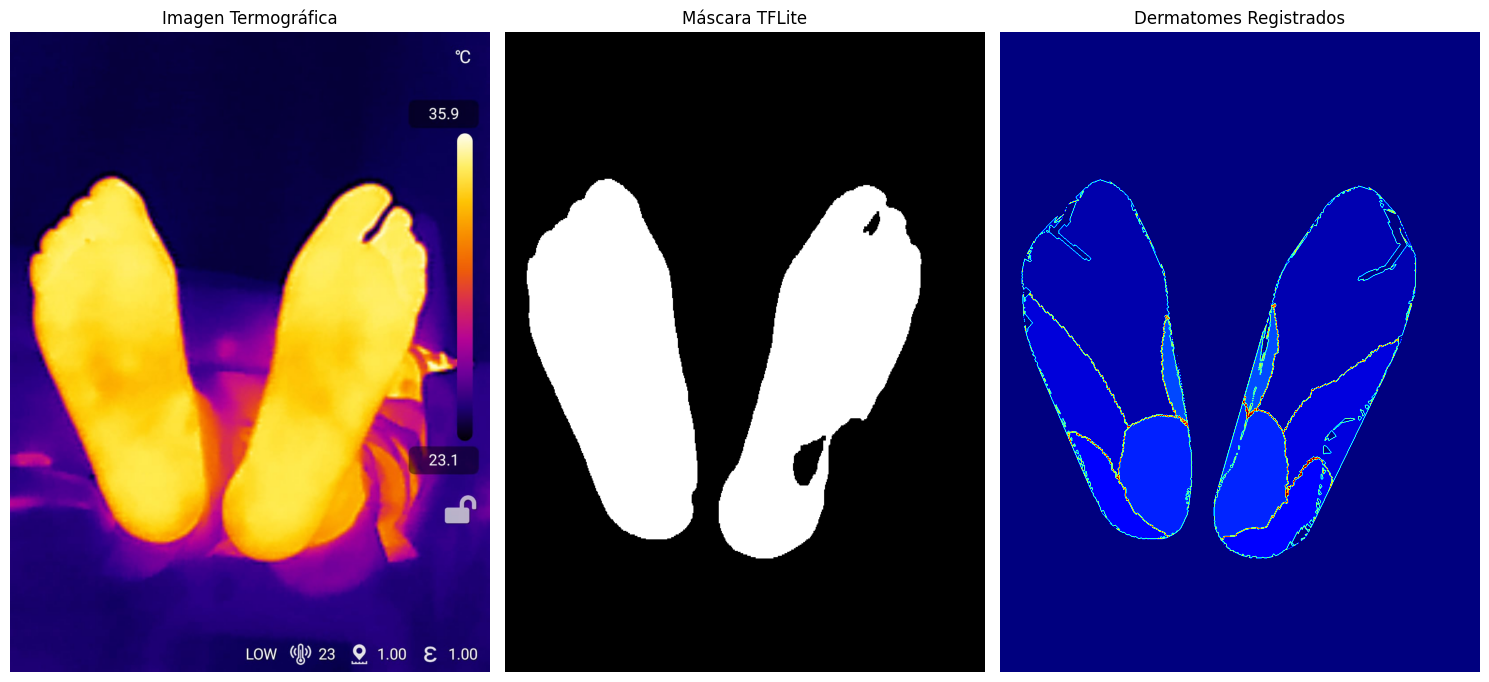

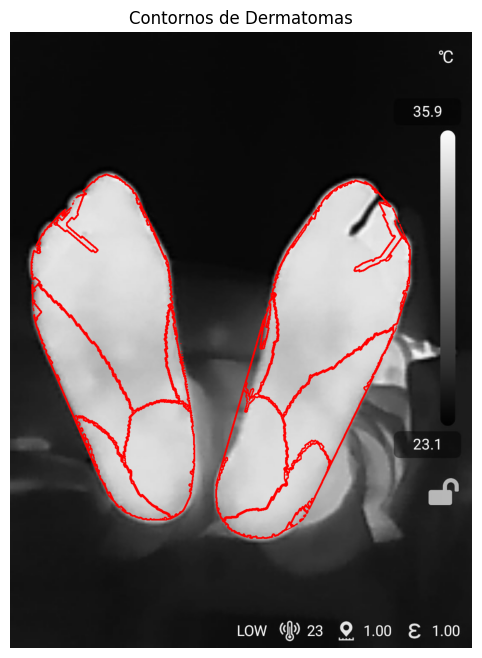

In [44]:
plot_results(results)